# Курсовая работа #

**<font size="6">Цель: детектирование детской бактериальной и вирусной пневмонии</font>**\
**<font size="6">Задача: бинарная классификация изображений</font>**

### Импорт библиотек ###

In [ ]:
import os
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt 
import random
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import gc

In [ ]:
from keras.applications import *
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet

### Определение рабочих директорий ###


In [22]:
base_dir = 'chest_xray/'

train_pneumonia_dir = base_dir+'train/PNEUMONIA/'
train_normal_dir=base_dir+'train/NORMAL/'

test_pneumonia_dir = base_dir+'test/PNEUMONIA/'
test_normal_dir = base_dir+'test/NORMAL/'

val_normal_dir= base_dir+'val/NORMAL/'
val_pnrumonia_dir= base_dir+'val/PNEUMONIA/'

### Формат датасета ###

In [23]:
train_pn = [train_pneumonia_dir+"{}".format(i) for i in os.listdir(train_pneumonia_dir) ]
train_normal = [train_normal_dir+"{}".format(i) for i in os.listdir(train_normal_dir) ]

test_normal = [test_normal_dir+"{}".format(i) for i in os.listdir(test_normal_dir)]
test_pn = [test_pneumonia_dir+"{}".format(i) for i in os.listdir(test_pneumonia_dir)]

val_pn= [val_pnrumonia_dir+"{}".format(i) for i in os.listdir(val_pnrumonia_dir) ]
val_normal= [val_normal_dir+"{}".format(i) for i in os.listdir(val_normal_dir) ]

print ("Количество изображений:",len(train_pn+train_normal+test_normal+test_pn+val_pn+val_normal))
print ("Положительных:",len(train_pn+test_pn+val_pn))
print ("Отрицтельных:",len(train_normal+test_normal+val_normal))

Количество изображений: 5856
Положительных: 4273
Отрицтельных: 1583


## Формирование наборов данных для тренировки, тестирования и валидации ## 
### Было решено использовать классическое распределение 80%, 15%, 5% ###

In [24]:
pn = train_pn + test_pn + val_pn
normal = train_normal + test_normal + val_normal

train_imgs = pn[:3418]+ normal[:1224]           # 80%
test_imgs = pn[3418:4059]+ normal[1224:1502]    # 15%
val_imgs = pn[4059:] + normal[1502:]            # 5%

print("Изображений для обучения:          %s : (%s '+' ; %s '-')" 
      % (len(train_imgs),len(pn[:3418]),len(normal[:1224])))
print("Изображений для тестирования:      %s : (%s '+' ; %s '-')"
      % (len(test_imgs),len(pn[3418:4059]),len(normal[1224:1502])))
print("Изображений для валидации:         %s : (%s '+' ; %s '-')" 
      % (len(val_imgs),len(pn[4059:]),len(normal[1502:])))

random.shuffle(train_imgs)
random.shuffle(test_imgs)
random.shuffle(val_imgs)

Изображений для обучения:          4642 : (3418 '+' ; 1224 '-')
Изображений для тестирования:      919 : (641 '+' ; 278 '-')
Изображений для валидации:         295 : (214 '+' ; 81 '-')


### Элемент из набора данных - путь к изображению ###

In [25]:
print(test_imgs[5])

chest_xray/train/PNEUMONIA/person922_bacteria_2847.jpeg


### Формирование массивов пар: {изображение -> класс} ###

In [26]:
img_size = 224
def preprocess_image(image_list):
    
    X = [] # изображения
    y = [] # классы (0 - отрицательный результат, 1 - положительный)
    count = 0
    
    for image in image_list:
        try:
            img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img,(img_size,img_size), interpolation=cv2.INTER_CUBIC)
            
            #convert image to 2D to 3D 
            img = np.dstack([img, img, img])
            
            #convrt greyscale image to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Normalalize Image
            img = img.astype(np.float32) / 255.
            
            count = count + 1
            X.append(img) 

        except:
            continue

        if 'NORMAL' in image:
            y.append(0)        
        elif 'IM' in image:
            y.append(0)
        elif 'virus' or 'bacteria' in image:
            y.append(1)
            
    return X, y

### Функция для проверки классов и выборочной визуализации данных ###

In [27]:
def check_and_visualise(X, y):
    
    arr = y	
    uniqueValues, occurCount = np.unique(arr, return_counts=True)
    
    print("Уникальные значения : " , uniqueValues)
    print("Распределение : ", occurCount)

    fig = plt.figure(figsize=(20, 5))
    k = 1
    for i in range(4):
        a = fig.add_subplot(1, 4, k)
        if (y[i]==0):
            a.set_title('Normal')
        else:
            a.set_title('Pneumonia')
            
        plt.imshow(X[i])
        k = k + 1


### Обучающие данные ###

Уникальные значения :  [0 1]
Распределение :  [1224 3418]


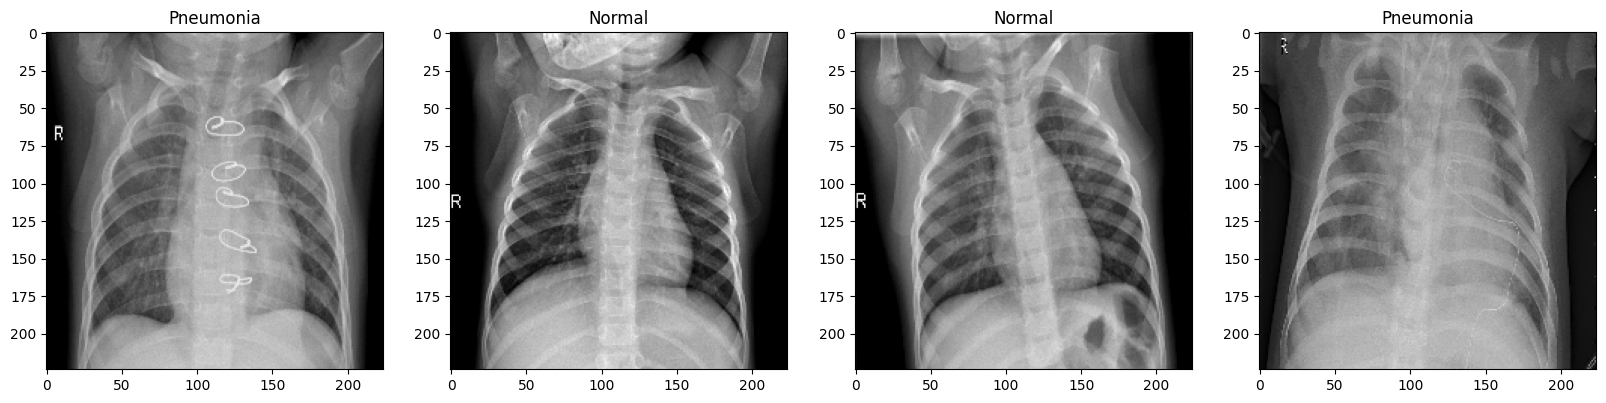

In [28]:
X, y = preprocess_image(train_imgs)
check_and_visualise(X, y)

### Тестовые данные ###

Уникальные значения :  [0 1]
Распределение :  [278 641]


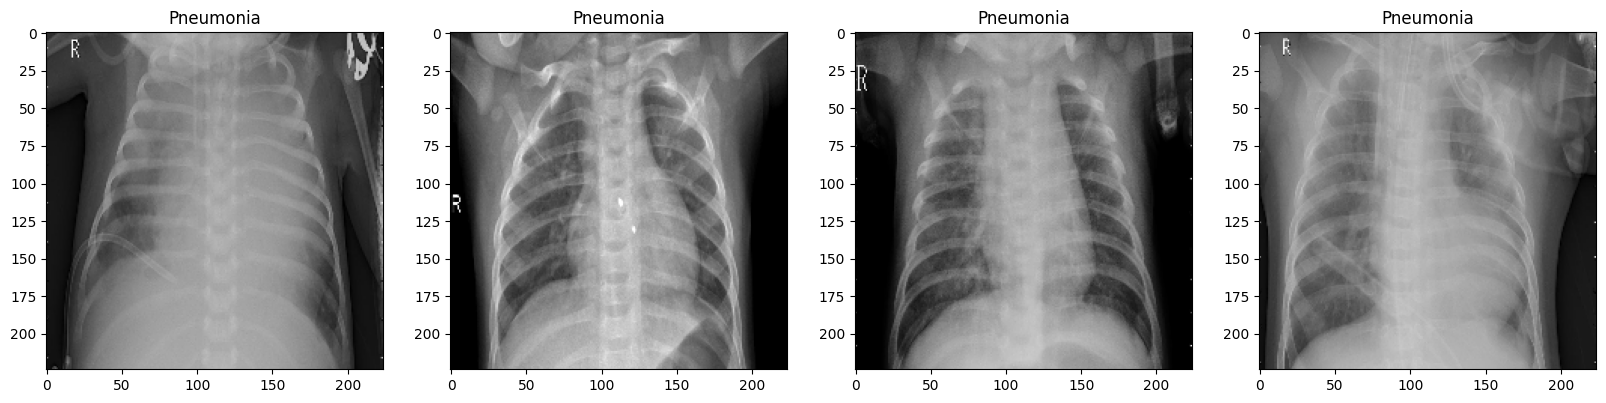

In [29]:
P, t = preprocess_image(test_imgs)
check_and_visualise(P, t)

### Валидационные данные 

Уникальные значения :  [0 1]
Распределение :  [ 81 214]


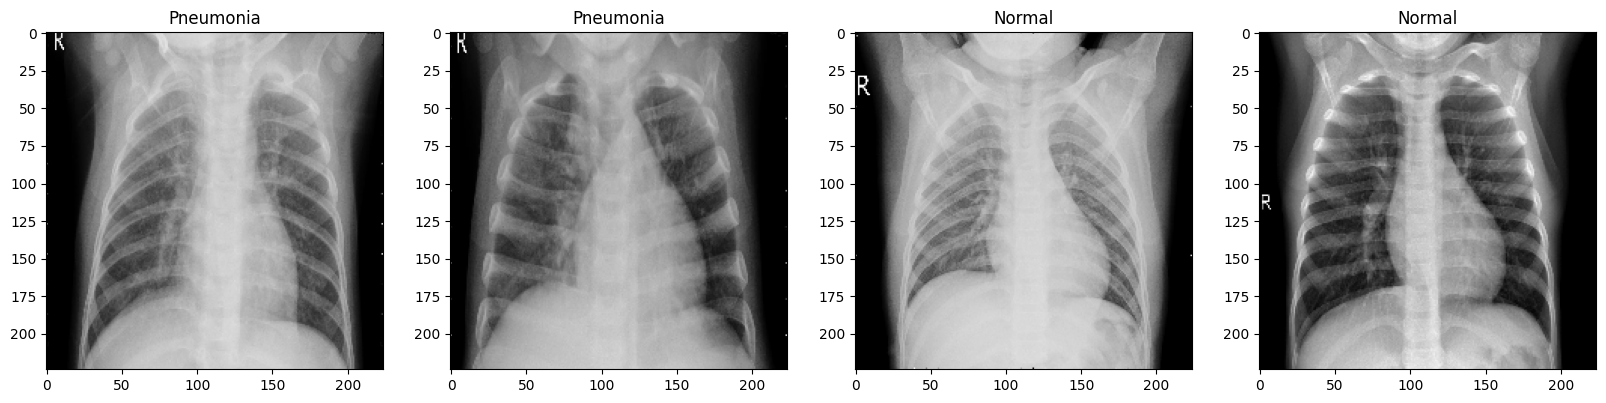

In [30]:
K, m = preprocess_image(val_imgs)
check_and_visualise(K, m)

## Определение веса для каждого класса ##

### Один из самых простых способов решить классовый дисбаланс - это просто определить вес для каждого класса, при котором больше внимания уделяется меньшинствам. Здесь мы используем функцию sklearn compute class weight для установки веса. Теперь модель может одинаково точно определять каждый класс.


In [31]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 1.8962418300653594, 1: 0.679052077238151}


### Форматы набров данных

In [32]:
train_imgs = train_pn[:3875]+ train_normal[:1341]
del train_imgs
gc.collect()

X_train = np.array(X)
y_train = np.array(y)
X_test = np.array(P)
y_test = np.array(t)
X_val = np.array(K)
y_val = np.array(m)

print('ОБУЧЕНИЕ \nИзображения:', X_train.shape, ' Классы:', y_train.shape)
print('ТЕСТИРОВАНИЕ \nИзображения:', X_test.shape, ' Классы:', y_test.shape)
print('ВАЛИДАЦИЯ \nИзображения:', X_val.shape, ' Классы:', y_val.shape)

ОБУЧЕНИЕ 
Изображения: (4642, 224, 224, 3)  Классы: (4642,)
ТЕСТИРОВАНИЕ 
Изображения: (919, 224, 224, 3)  Классы: (919,)
ВАЛИДАЦИЯ 
Изображения: (295, 224, 224, 3)  Классы: (295,)



## Обучение 

### Был выбран размер батча равный 32

In [33]:
del X
del y
gc.collect()

ntrain = len(X_train)
nval = len(X_val)

batch_size = 32

## Аугументация изображений ##
### Чтобы компенсировать недостатки использования маленького набора данных, были применены методы аугментации изображений 

In [34]:
train_datagen = ImageDataGenerator(  rotation_range=7,
                                     width_shift_range=0.05,
                                     height_shift_range=0.05,
                                     shear_range=0.2,
                                     zoom_range=0.45,
                                     horizontal_flip=True)
                                   
val_datagen = ImageDataGenerator(zoom_range=0.45)  

In [35]:
#Create the image generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

## Ядро алгоритма - MobileNet

### Использование предобученной CNN MobileNet позволяет выполнить компиляцию кода без задействия значительных вычислительныйх мощностей

In [36]:
base_model = MobileNet(weights=None, include_top=False,input_shape=(img_size, img_size, 3)) 

x = base_model.output

# GAP слой
x = GlobalAveragePooling2D()(x)

# Полносвязный слой
predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])

### Архитектура сети

In [40]:
# We can see details of  MobileNet architecure's details
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,229,889 (12.32 MB)

 Trainable params: 3,208,001 (12.24 MB)

 Non-trainable params: 21,888 (85.50 KB)

### Обучение модели

In [41]:
history = model.fit(train_generator,
                    steps_per_epoch=ntrain // batch_size,
                    epochs=64,
                    validation_data=val_generator,
                    validation_steps=nval // batch_size,
                    class_weight=class_weights
)

Epoch 1/64


c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


145/145 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - binary_accuracy: 0.7948 - loss: 0.4828 - mae: 0.2646 - val_binary_accuracy: 0.7326 - val_loss: 2.3098 - val_mae: 0.2674
Epoch 2/64
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - binary_accuracy: 0.8750 - loss: 0.2711 - mae: 0.1816 - val_binary_accuracy: 0.4286 - val_loss: 4.9759 - val_mae: 0.5714
Epoch 3/64


c:\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


145/145 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - binary_accuracy: 0.8775 - loss: 0.2901 - mae: 0.1594 - val_binary_accuracy: 0.7222 - val_loss: 2.8144 - val_mae: 0.2778
Epoch 4/64
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 487us/step - binary_accuracy: 0.8438 - loss: 0.2180 - mae: 0.1596 - val_binary_accuracy: 0.8571 - val_loss: 1.4546 - val_mae: 0.1429
Epoch 5/64
145/145 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - binary_accuracy: 0.8856 - loss: 0.2614 - mae: 0.1495 - val_binary_accuracy: 0.7292 - val_loss: 2.8979 - val_mae: 0.2708
Epoch 6/64
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 473us/step - binary_accuracy: 0.9062 - loss: 0.1767 - mae: 0.1310 - val_binary_accuracy: 0.5714 - val_loss: 4.5835 - val_mae: 0.4286
Epoch 7/64
145/145 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - binary_accuracy: 0.8980 - loss: 0.2401 - mae: 0.1371 - val_binary_accuracy: 0.7326 - val_loss: 2.6873 - val_mae: 0.2674
Epoch 8/64
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 598us/step - binary_accuracy: 0.8750 - loss: 0.4068 - mae: 0.1828 - val_binary_accuracy: 0.

### Графическое представление результатов обучения: точность и потери на каждой эпохе

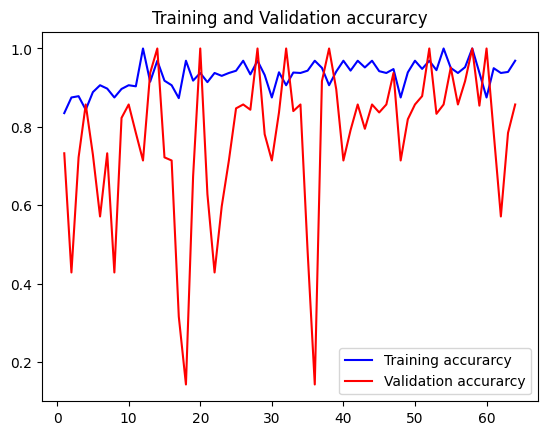

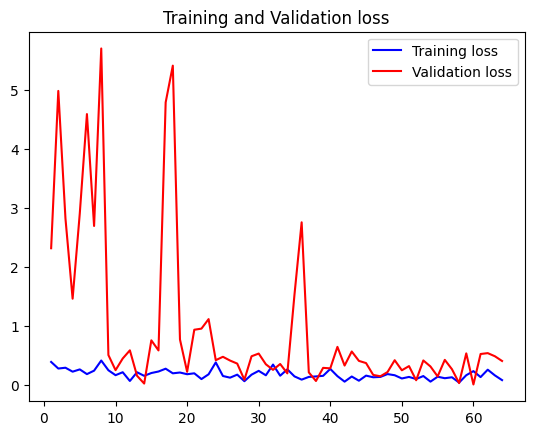

In [ ]:
model.save('model.keras')

# Из истории обучения забираем характеристки
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Выводим характеристики на графики
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

## Тестирование: оценка эффективности классификации
### Для объективности использовались несколько оценочных характеристик: Accuracy, Recall, Precision, F1 и AUC.

In [43]:
preds = model.predict(X_test)

acc = accuracy_score(y_test, np.round(preds))*100
cm = confusion_matrix(y_test, np.round(preds))

tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\n============TEST METRICS=============')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((history.history['binary_accuracy'][-1])*100, 2)))

29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 258ms/step
CONFUSION MATRIX ------------------
[[102 176]
 [  9 632]]

============TEST METRICS=============
Accuracy: 79.86942328618063%
Precision: 78.21782178217822%
Recall: 98.59594383775351%
F1-score: 87.23257418909593

TRAIN METRIC ----------------------
Train acc: 96.88


### Наглядное предстваление точности классификации при помощи теполовой карты

<Axes: >

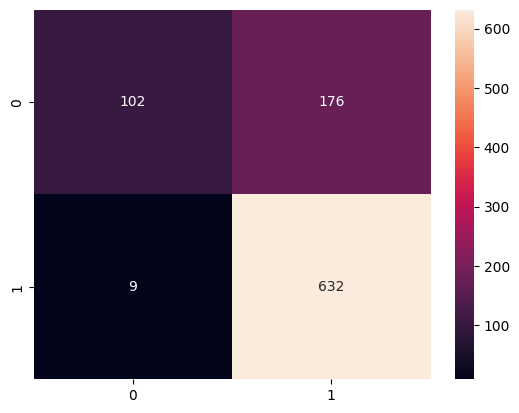

In [ ]:
sns.heatmap(cm, annot=True, fmt="d",)

### ROC-кривая (receiver operating characteristic curve) показывает диагностическую точность и соответствие модели. Мы показываем кривую ROC, а также рассчитываем показатель AUC (area under the ROC curve)

AUC Score: 0.8961043333819683


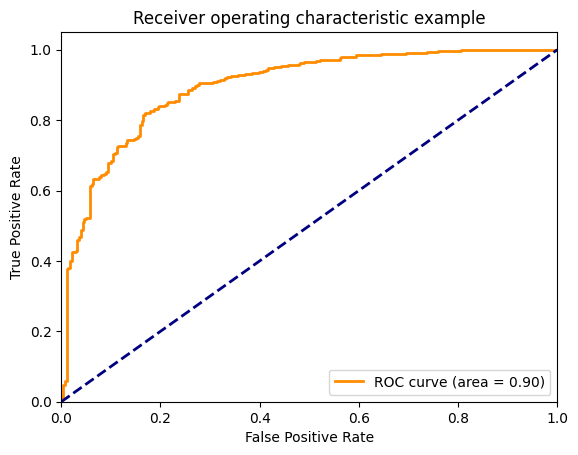

In [44]:
fpr , tpr , thresholds = roc_curve ( y_test , preds)
auc_keras = auc(fpr, tpr)
print("AUC Score:",auc_keras)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_keras)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Вывод: 
### В результате проведенного исследования было установлено, что предложенная модель показывает высокие результаты на оценках, что подтверждает её эффективность в решении поставленной задачи. Однако, несмотря на достигнутые успехи, существует потенциал для дальнейшего улучшения архитектуры. Самые очевидные способы роста эффективности: выбор более обьемного набора данных и увеличение аппаратной мощности для обучения. Кроме того стоит также активно применять методы передачи обучения и техники аугментации данных, которые могут значительно повысить точность и обобщающую способность модели. В дальнейшем это может привести к созданию более высокоэффективных решений.